# Inference comparison on simulated data

## Library imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import torch
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scvelo as scv
import scvi

sys.path.append("../..")
from paths import FIG_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'comparison', exist_ok=True)

## Function definitions

In [5]:
def get_adata(n_obs, mu, R, C, n_vars=1000):
    cov = C.dot(C.T) * R

    alpha, beta, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T)  # multivariate log-normal
    beta /= 3
    gamma /= 3

    # remove outliers
    idx = (alpha < np.percentile(alpha, 99)) & (beta < np.percentile(beta, 99)) & (gamma < np.percentile(gamma, 99))
    alpha = alpha[idx]
    beta = beta[idx]
    gamma = gamma[idx]
    n_vars = np.sum(idx)

    switches = np.random.uniform(.1, .5, size=n_vars)

    adata = scv.datasets.simulation(
        n_obs=n_obs,
        t_max=20,
        n_vars=n_vars,
        switches=switches,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        noise_level=.8
    )

    scv.pp.neighbors(adata)
    scv.tl.velocity(adata, mode='steady_state', use_raw=True)

    return adata

In [6]:
def fit_scvelo(adata):
    scv.tl.recover_dynamics(
        adata, var_names=adata.var_names, use_raw=True, n_jobs=8
    )

In [7]:
def fit_velovi(bdata):
    from velovi import VELOVI

    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    latent_time = vae.get_latent_time(n_samples=25)
    t = latent_time
    scaling = 20 / t.max(0)

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

## Correlation analysis

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/972 [00:00<?, ?gene/s]

    finished (0:00:41) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


/home/icb/philipp.weiler/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 470/500:  94%|█████████▍| 470/500 [01:07<00:04,  6.98it/s, loss=-1.27e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1265.620. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/975 [00:00<?, ?gene/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


    finished (0:00:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
Epoch 500/500: 100%|██████████| 500/500 [01:04<00:00,  7.75it/s, loss=-1.28e+03, v_num=1]
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


    finished (0:00:35) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
Epoch 500/500: 100%|██████████| 500/500 [01:03<00:00,  7.90it/s, loss=-1.22e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1229.235. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


    finished (0:00:35) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [01:09<00:00,  7.24it/s, loss=-1.26e+03, v_num=1]
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


    finished (0:00:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
Epoch 386/500:  77%|███████▋  | 386/500 [00:50<00:14,  7.66it/s, loss=-1.21e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1207.059. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


    finished (0:00:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
Epoch 420/500:  84%|████████▍ | 420/500 [00:53<00:10,  7.78it/s, loss=-1.22e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1221.485. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 448/500:  90%|████████▉ | 448/500 [00:59<00:06,  7.51it/s, loss=-1.24e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1232.561. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


    finished (0:00:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Set SLURM handle signals.


Epoch 480/500:  96%|█████████▌| 480/500 [01:01<00:02,  7.80it/s, loss=-1.23e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1230.982. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


    finished (0:00:37) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
Epoch 500/500: 100%|██████████| 500/500 [01:01<00:00,  8.09it/s, loss=-1.23e+03, v_num=1]
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


    finished (0:00:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
Epoch 462/500:  92%|█████████▏| 462/500 [01:00<00:04,  7.67it/s, loss=-1.23e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1229.542. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:41) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 316/500:  63%|██████▎   | 316/500 [01:16<00:44,  4.15it/s, loss=-1.2e+03, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1303.267. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:41) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [01:54<00:00,  4.37it/s, loss=-1.28e+03, v_num=1]
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 376/500:  75%|███████▌  | 376/500 [01:24<00:27,  4.43it/s, loss=-1.22e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1309.065. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:44) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 395/500:  79%|███████▉  | 395/500 [01:22<00:21,  4.78it/s, loss=-1.26e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1314.173. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:42) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 461/500:  92%|█████████▏| 461/500 [01:39<00:08,  4.65it/s, loss=-1.2e+03, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1334.286. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 312/500:  62%|██████▏   | 312/500 [01:05<00:39,  4.75it/s, loss=-1.23e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1280.445. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [01:46<00:00,  4.68it/s, loss=-1.26e+03, v_num=1]
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:38) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 335/500:  67%|██████▋   | 335/500 [01:13<00:36,  4.57it/s, loss=-1.24e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1300.102. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [01:52<00:00,  4.45it/s, loss=-1.3e+03, v_num=1] 
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:41) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 291/500:  58%|█████▊    | 291/500 [01:06<00:48,  4.35it/s, loss=-1.14e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1284.527. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 432/500:  86%|████████▋ | 432/500 [02:18<00:21,  3.12it/s, loss=-1.34e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1306.869. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/977 [00:00<?, ?gene/s]

    finished (0:00:48) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 500/500: 100%|██████████| 500/500 [02:40<00:00,  3.11it/s, loss=-1.36e+03, v_num=1]
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:00:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 298/500:  60%|█████▉    | 298/500 [01:32<01:02,  3.21it/s, loss=-1.34e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1303.765. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:53) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 398/500:  80%|███████▉  | 398/500 [02:24<00:37,  2.75it/s, loss=-1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1335.884. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/977 [00:00<?, ?gene/s]

    finished (0:00:54) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 488/500:  98%|█████████▊| 488/500 [03:43<00:05,  2.18it/s, loss=-1.36e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1327.219. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:00:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 406/500:  81%|████████  | 406/500 [02:07<00:29,  3.17it/s, loss=-1.36e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1319.682. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:46) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 385/500:  77%|███████▋  | 385/500 [02:07<00:38,  3.01it/s, loss=-1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1329.857. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/977 [00:00<?, ?gene/s]

    finished (0:00:48) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 409/500:  82%|████████▏ | 409/500 [02:07<00:28,  3.21it/s, loss=-1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1319.960. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:00:50) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 381/500:  76%|███████▌  | 381/500 [02:04<00:38,  3.07it/s, loss=-1.35e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1317.719. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:53) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 422/500:  84%|████████▍ | 422/500 [03:10<00:35,  2.22it/s, loss=-1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1338.951. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/977 [00:00<?, ?gene/s]

    finished (0:01:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 337/500:  67%|██████▋   | 337/500 [02:50<01:22,  1.97it/s, loss=-1.35e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1357.119. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/973 [00:00<?, ?gene/s]

    finished (0:00:55) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 420/500:  84%|████████▍ | 420/500 [03:00<00:34,  2.33it/s, loss=-1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1381.432. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:00:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 436/500:  87%|████████▋ | 436/500 [03:02<00:26,  2.39it/s, loss=-1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1367.330. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/975 [00:00<?, ?gene/s]

    finished (0:00:55) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 469/500:  94%|█████████▍| 469/500 [03:10<00:12,  2.47it/s, loss=-1.36e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1380.304. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/972 [00:00<?, ?gene/s]

    finished (0:00:54) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 240/500:  48%|████▊     | 240/500 [01:37<01:45,  2.47it/s, loss=-1.35e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1345.444. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/976 [00:00<?, ?gene/s]

    finished (0:00:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 290/500:  58%|█████▊    | 290/500 [03:47<02:45,  1.27it/s, loss=-1.34e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1355.669. Signaling Trainer to stop.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:02:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 323/500:  65%|██████▍   | 323/500 [03:12<01:45,  1.68it/s, loss=-1.36e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1351.550. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/975 [00:00<?, ?gene/s]

    finished (0:01:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 397/500:  79%|███████▉  | 397/500 [03:52<01:00,  1.71it/s, loss=-1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1377.976. Signaling Trainer to stop.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/972 [00:00<?, ?gene/s]

    finished (0:02:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 248/500:  50%|████▉     | 248/500 [03:46<03:49,  1.10it/s, loss=-1.35e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1346.314. Signaling Trainer to stop.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/976 [00:00<?, ?gene/s]

    finished (0:02:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 267/500:  53%|█████▎    | 267/500 [03:50<03:21,  1.16it/s, loss=-1.33e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1345.556. Signaling Trainer to stop.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:02:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 350/500:  70%|███████   | 350/500 [06:13<02:40,  1.07s/it, loss=-1.38e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1410.588. Signaling Trainer to stop.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:02:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 220/500:  44%|████▍     | 220/500 [03:49<04:52,  1.04s/it, loss=-1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1396.596. Signaling Trainer to stop.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:02:16) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 245/500:  49%|████▉     | 245/500 [03:25<03:34,  1.19it/s, loss=-1.37e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1406.321. Signaling Trainer to stop.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:01:20) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 251/500:  50%|█████     | 251/500 [01:57<01:56,  2.14it/s, loss=-1.38e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1410.348. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:01:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 330/500:  66%|██████▌   | 330/500 [03:43<01:55,  1.48it/s, loss=-1.38e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1417.353. Signaling Trainer to stop.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:02:12) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 414/500:  83%|████████▎ | 414/500 [07:38<01:35,  1.11s/it, loss=-1.38e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1423.826. Signaling Trainer to stop.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:02:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 406/500:  81%|████████  | 406/500 [05:44<01:19,  1.18it/s, loss=-1.38e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1421.526. Signaling Trainer to stop.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:02:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 295/500:  59%|█████▉    | 295/500 [05:20<03:42,  1.09s/it, loss=-1.39e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1415.200. Signaling Trainer to stop.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:02:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 459/500:  92%|█████████▏| 459/500 [05:04<00:27,  1.51it/s, loss=-1.39e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1427.969. Signaling Trainer to stop.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 8/112 cores)


  0%|          | 0/974 [00:00<?, ?gene/s]

    finished (0:01:25) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 338/500:  68%|██████▊   | 338/500 [05:42<02:44,  1.01s/it, loss=-1.38e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1418.913. Signaling Trainer to stop.


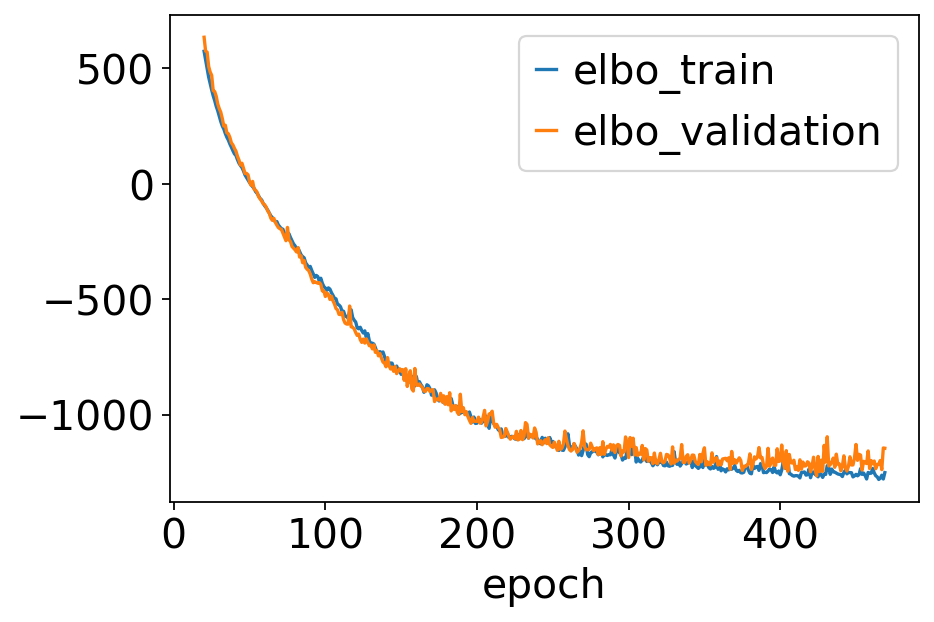

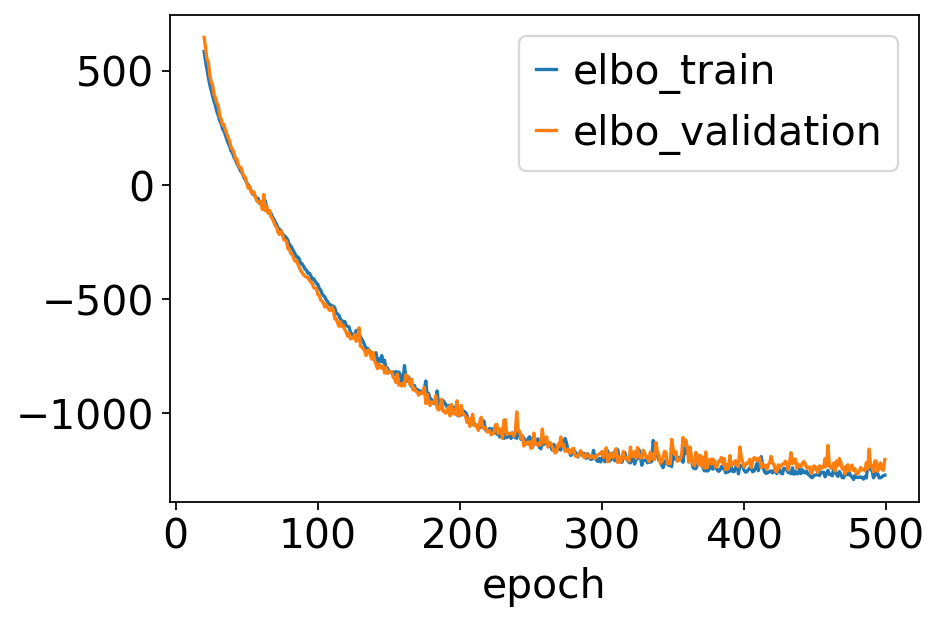

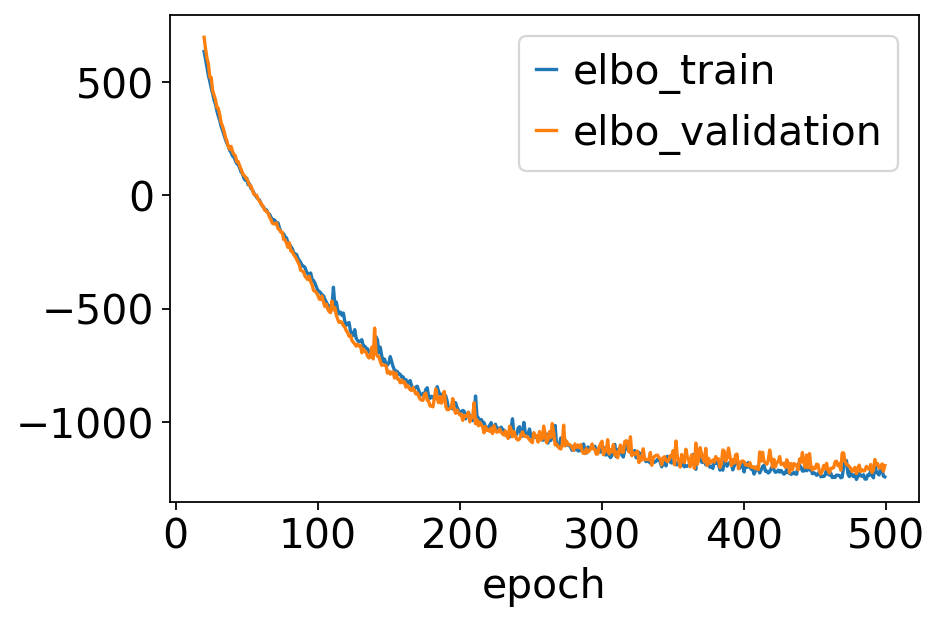

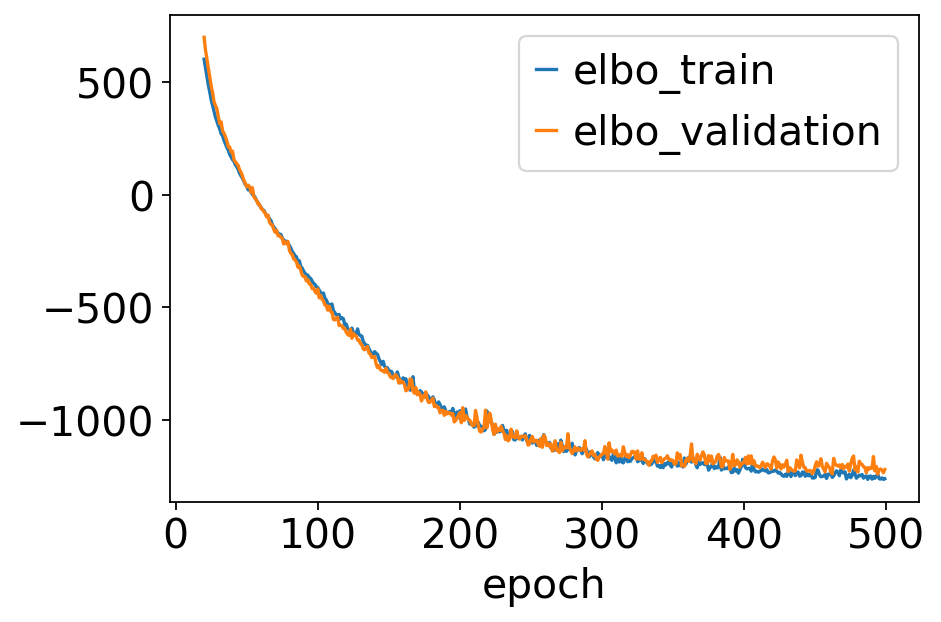

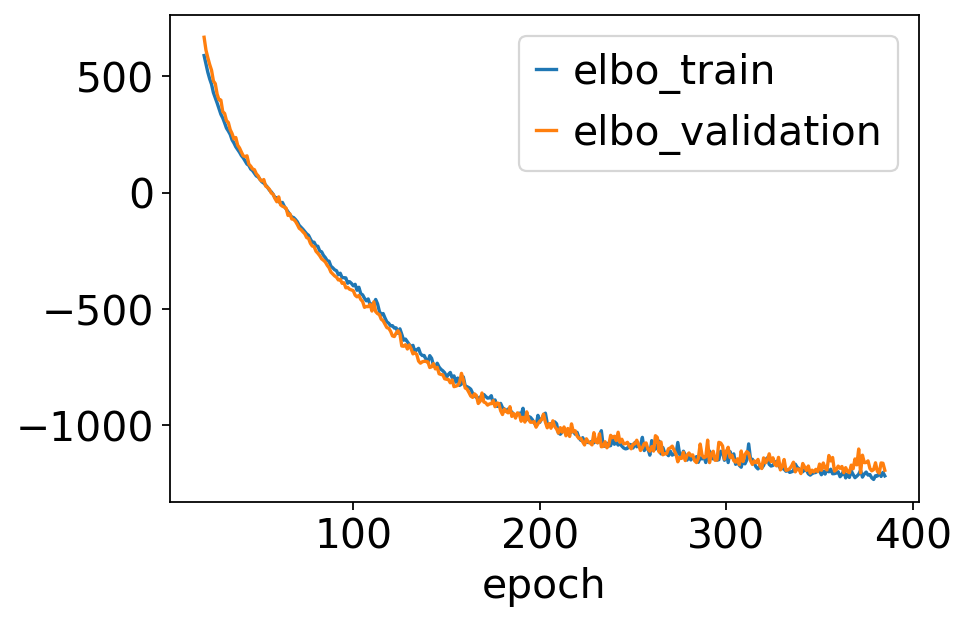

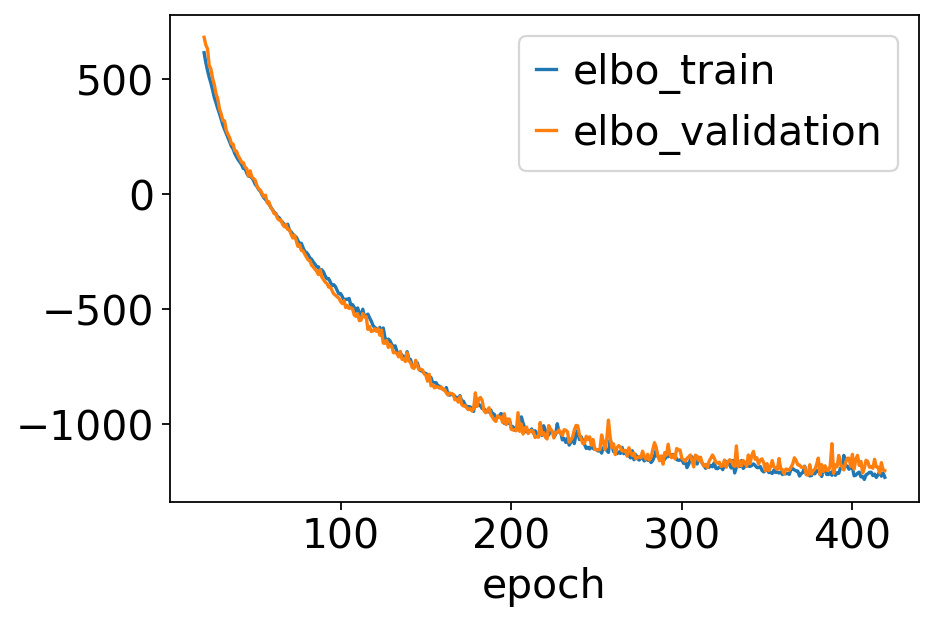

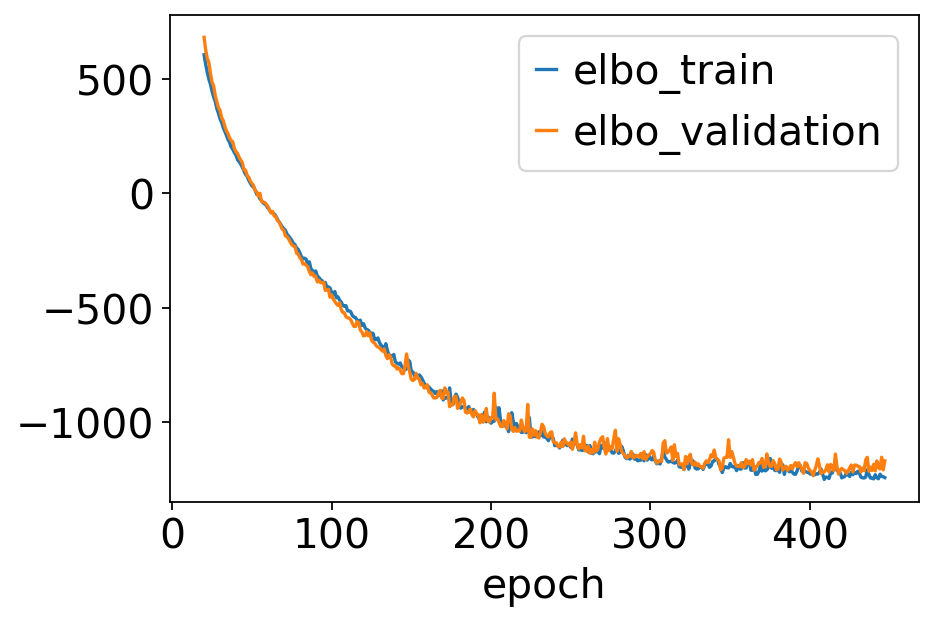

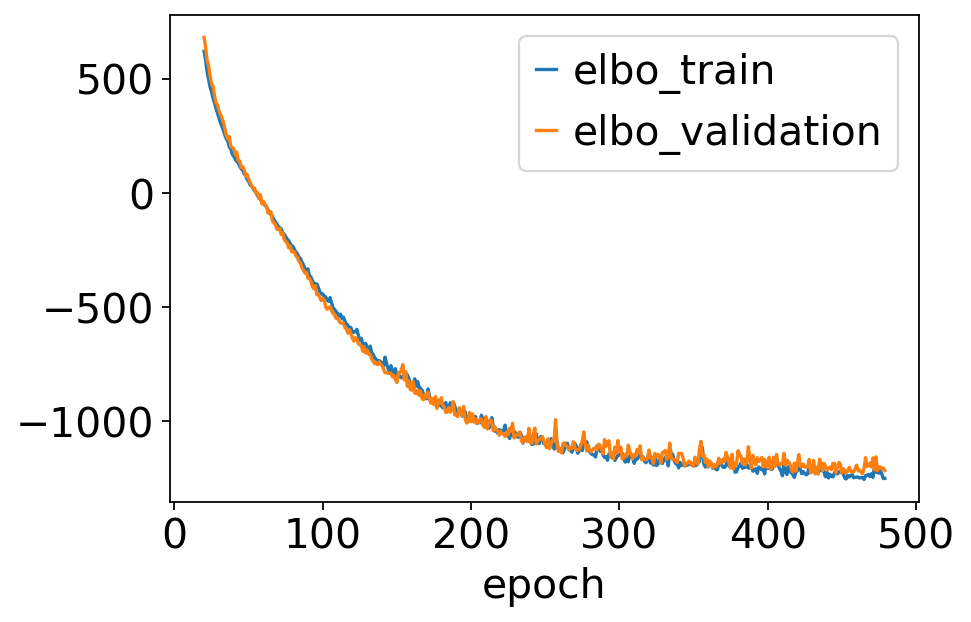

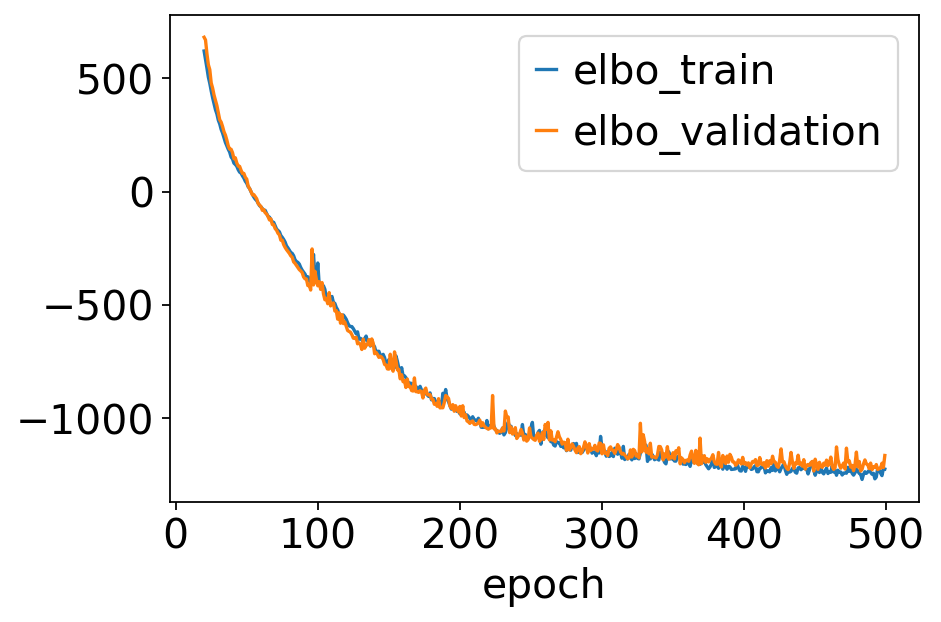

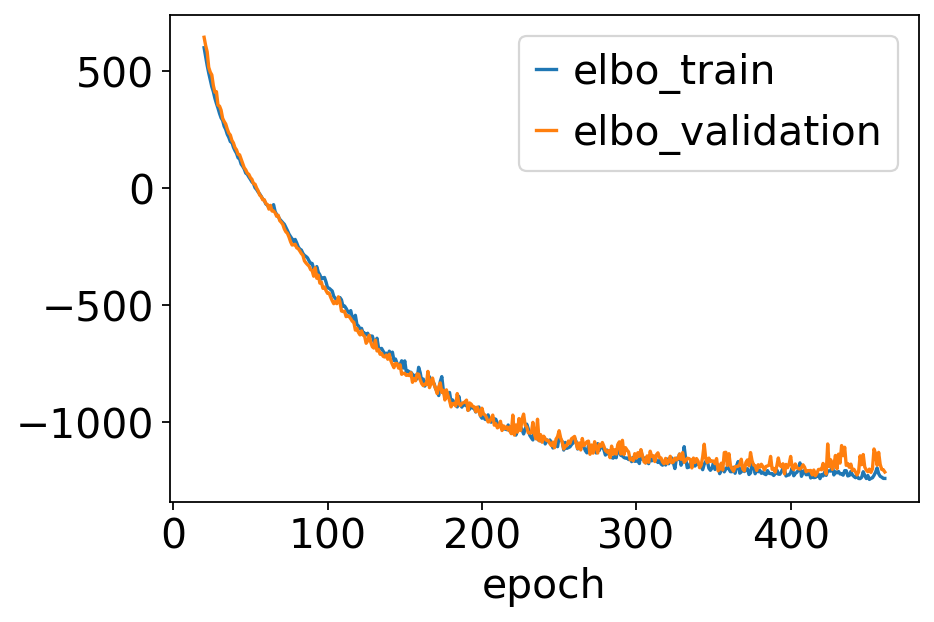

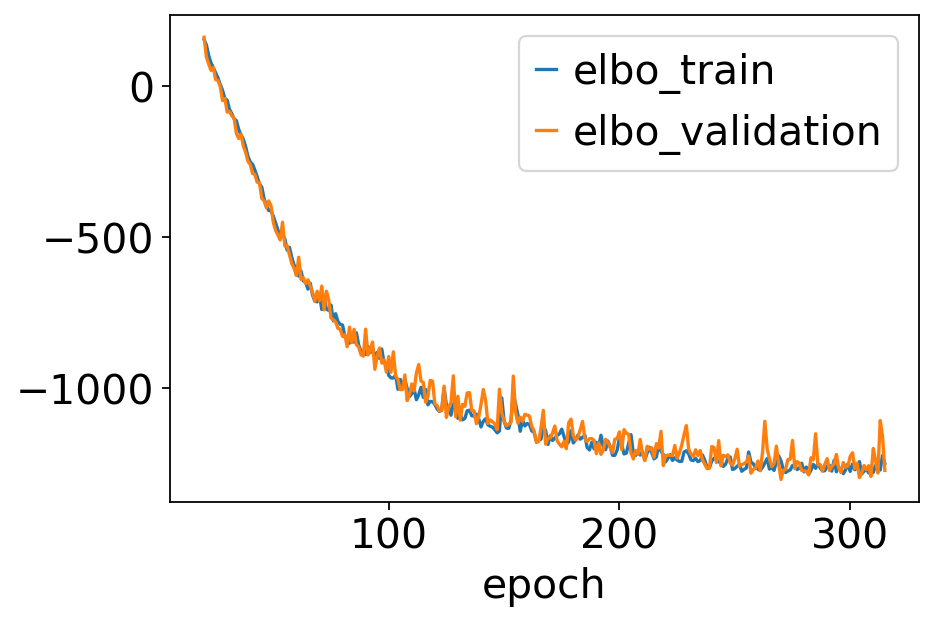

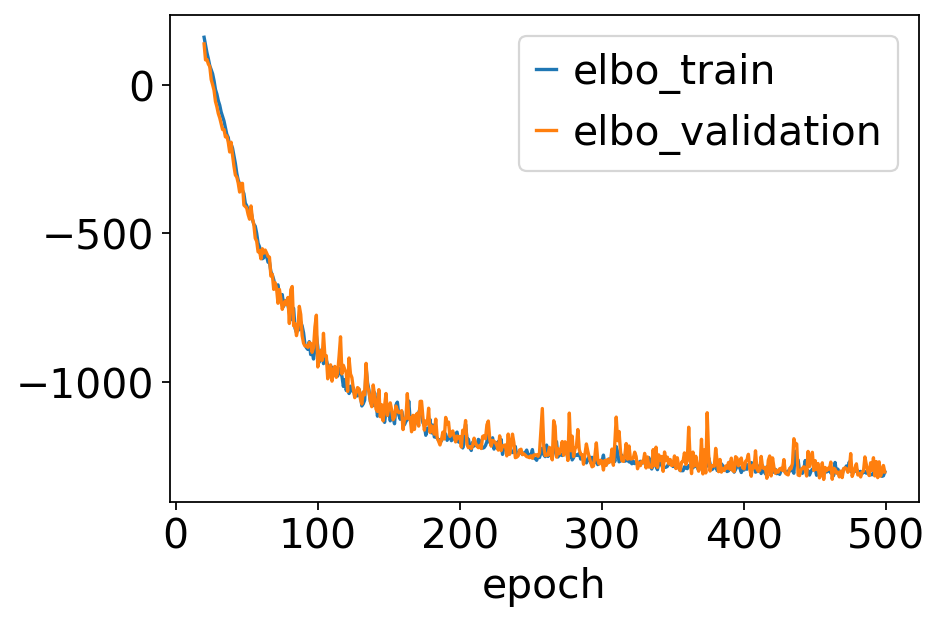

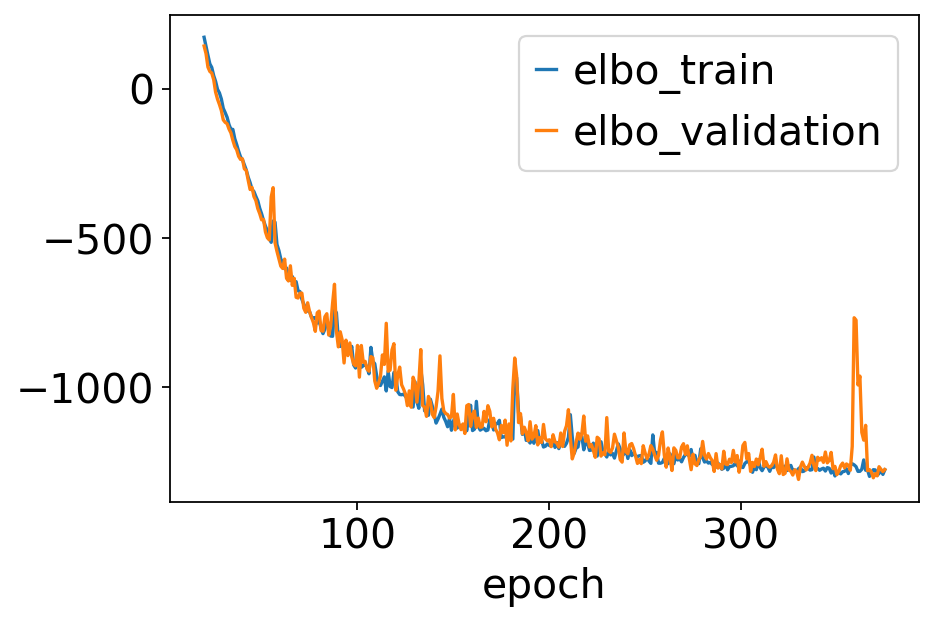

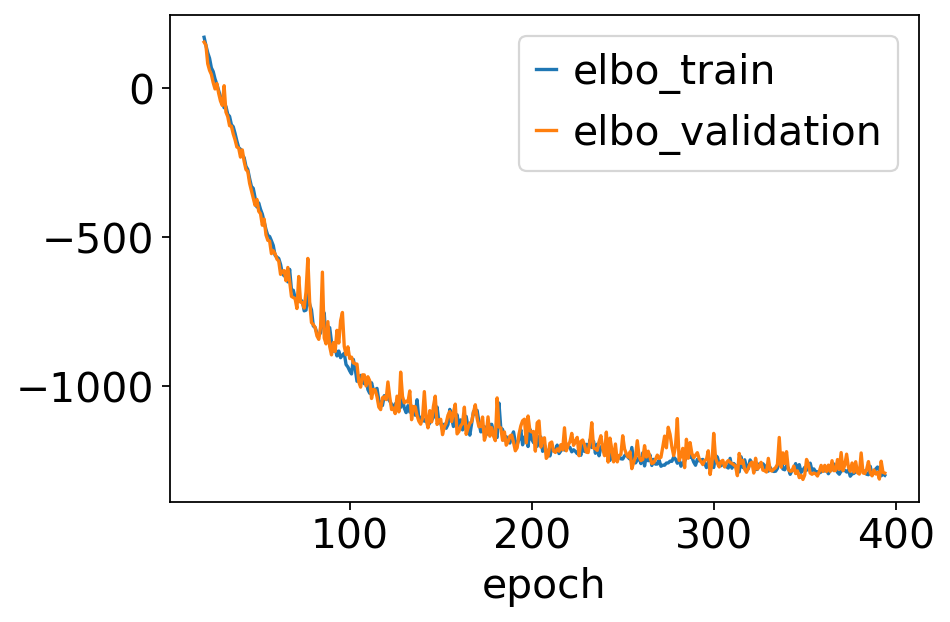

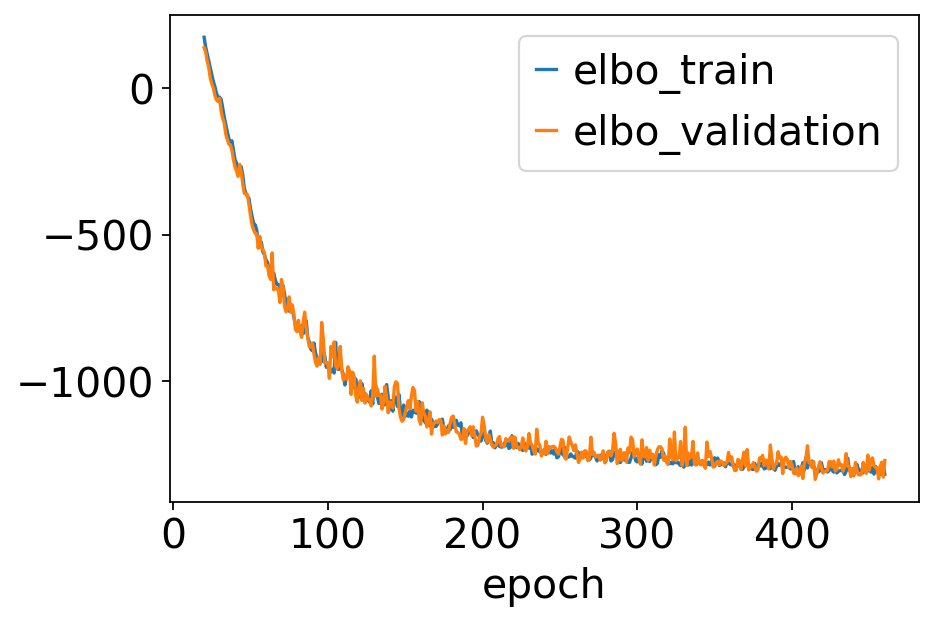

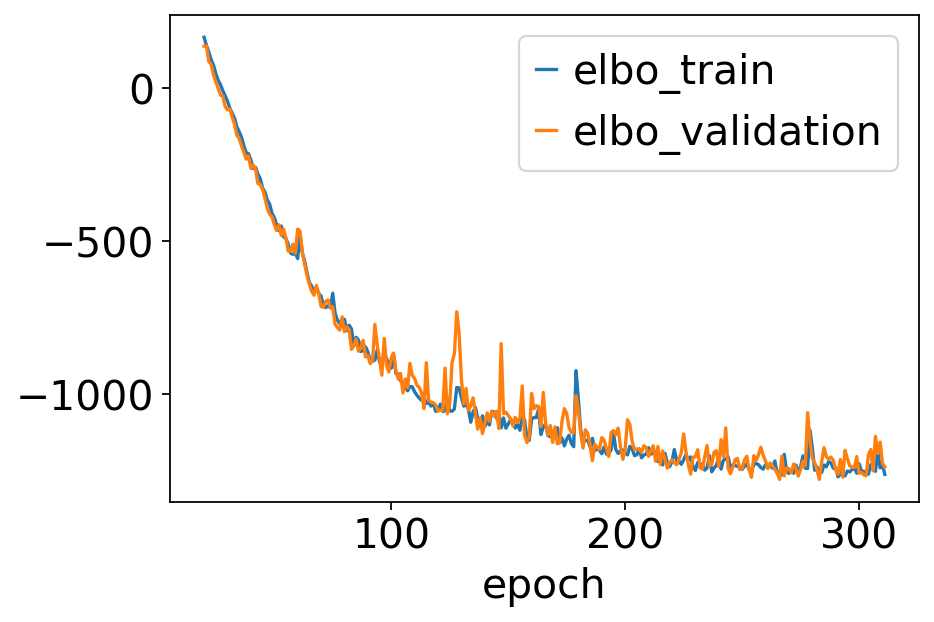

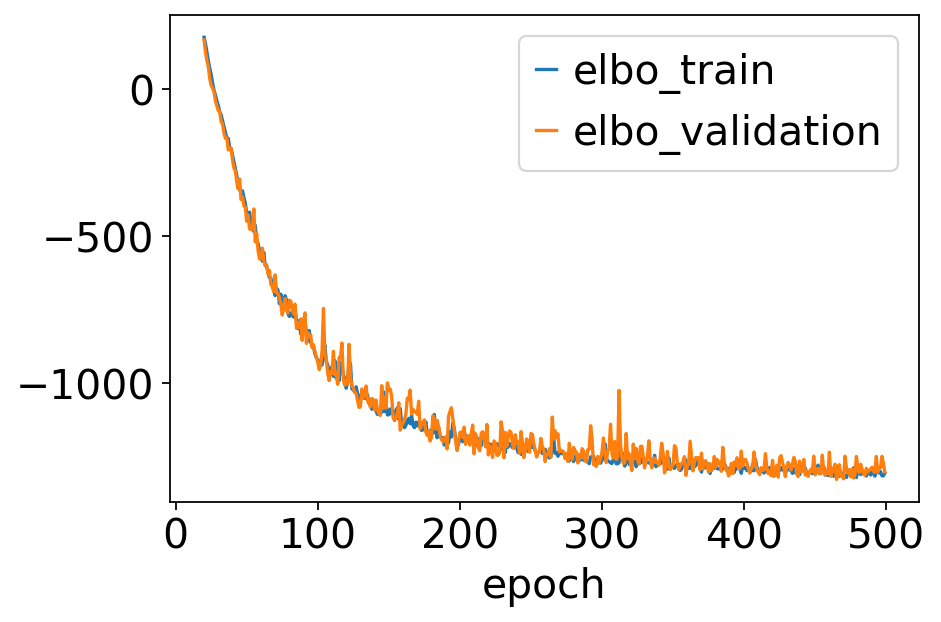

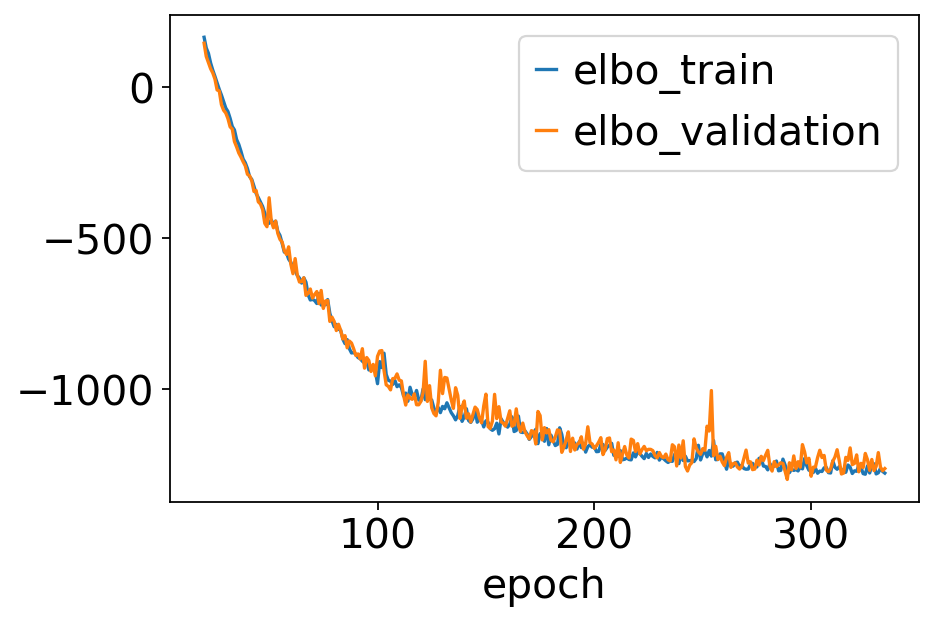

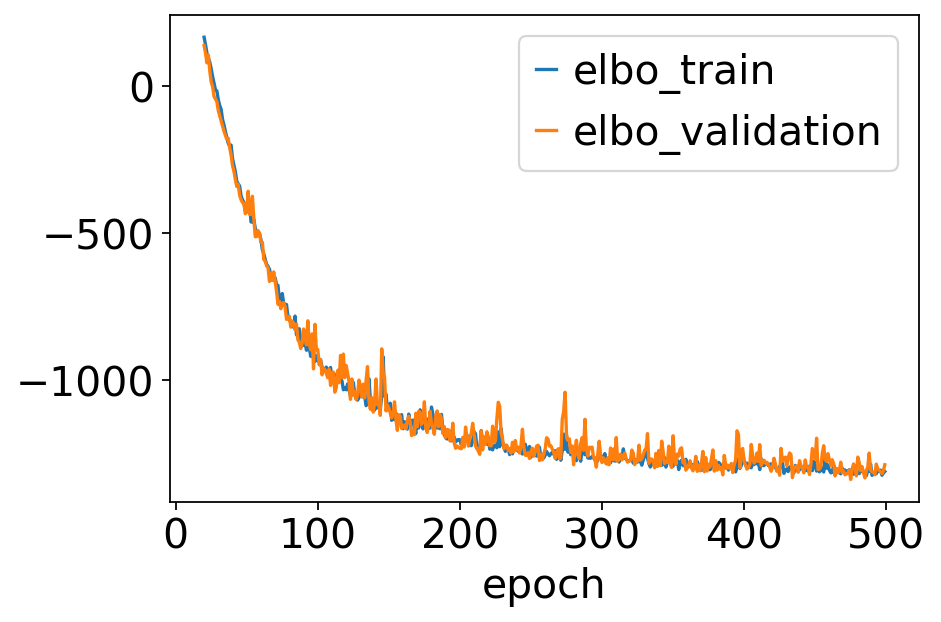

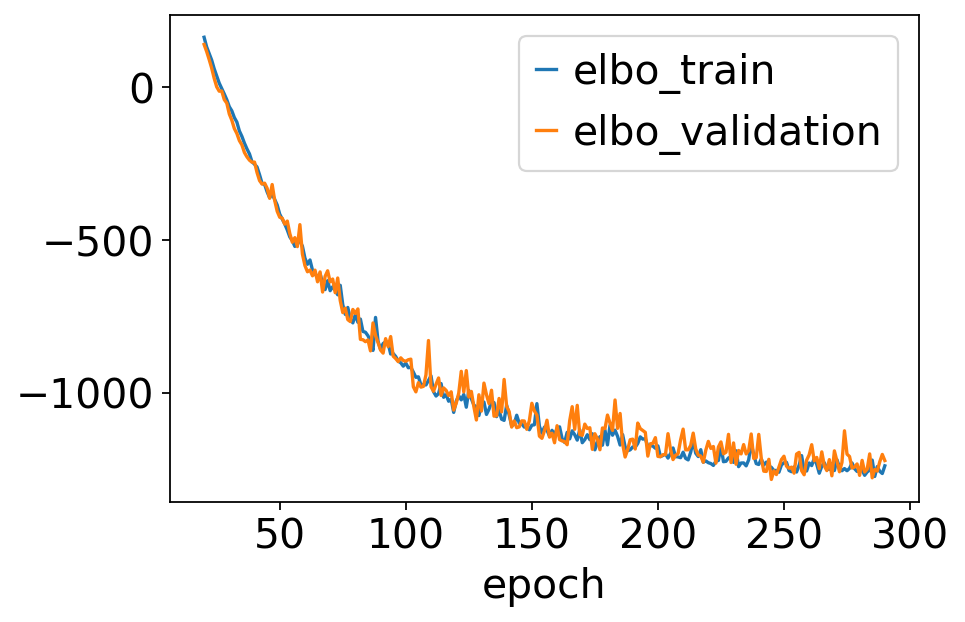

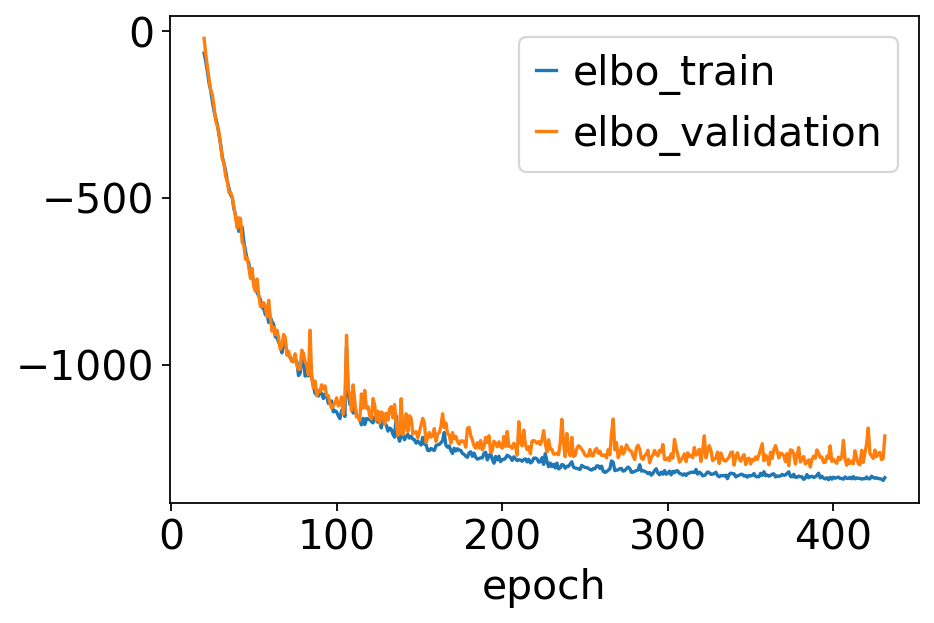

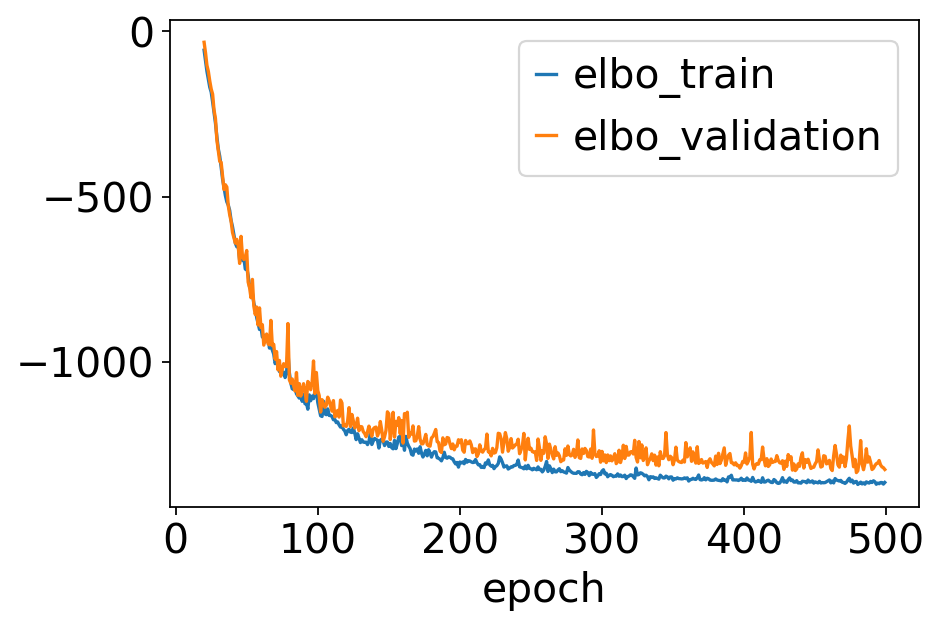

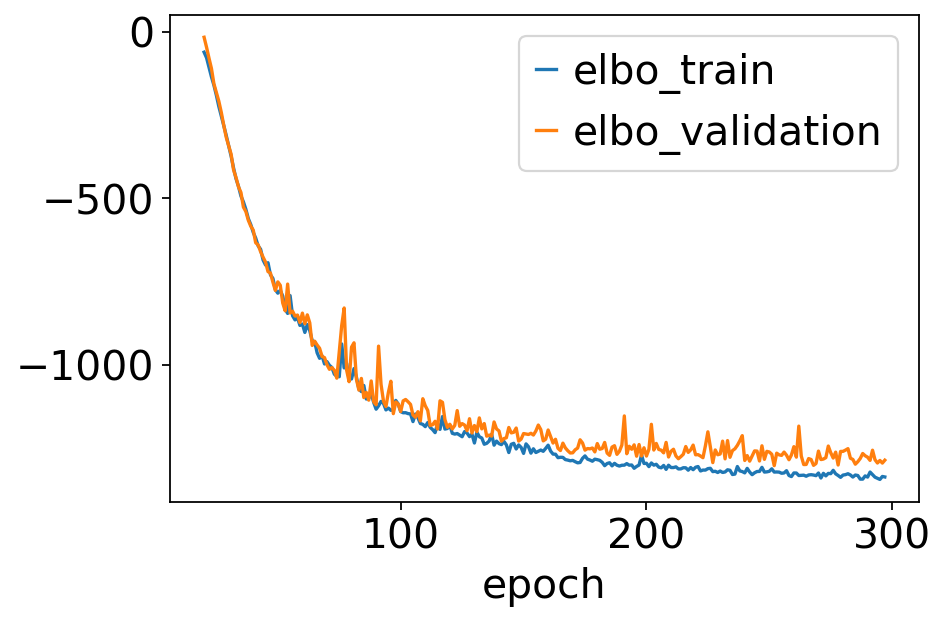

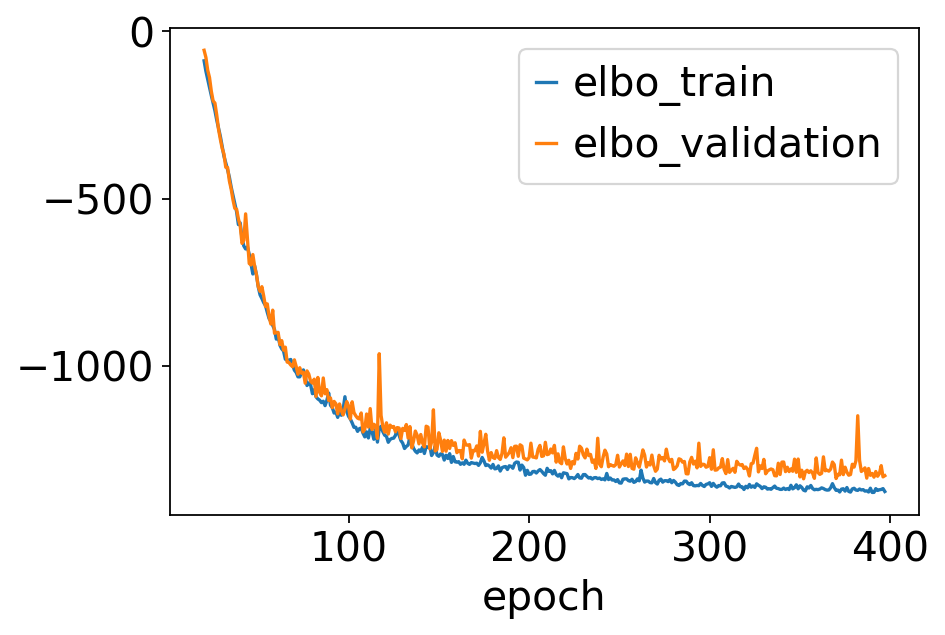

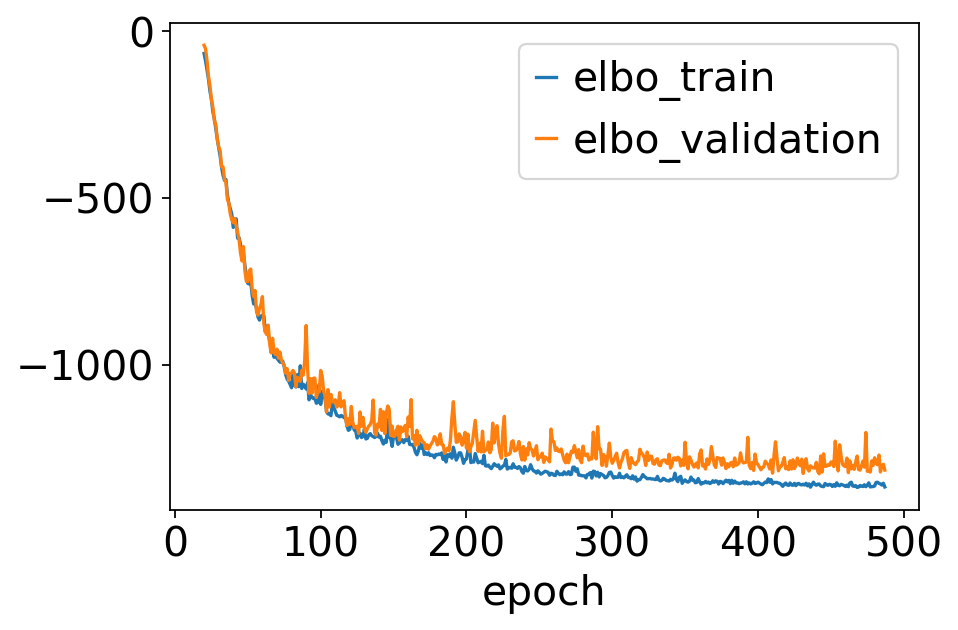

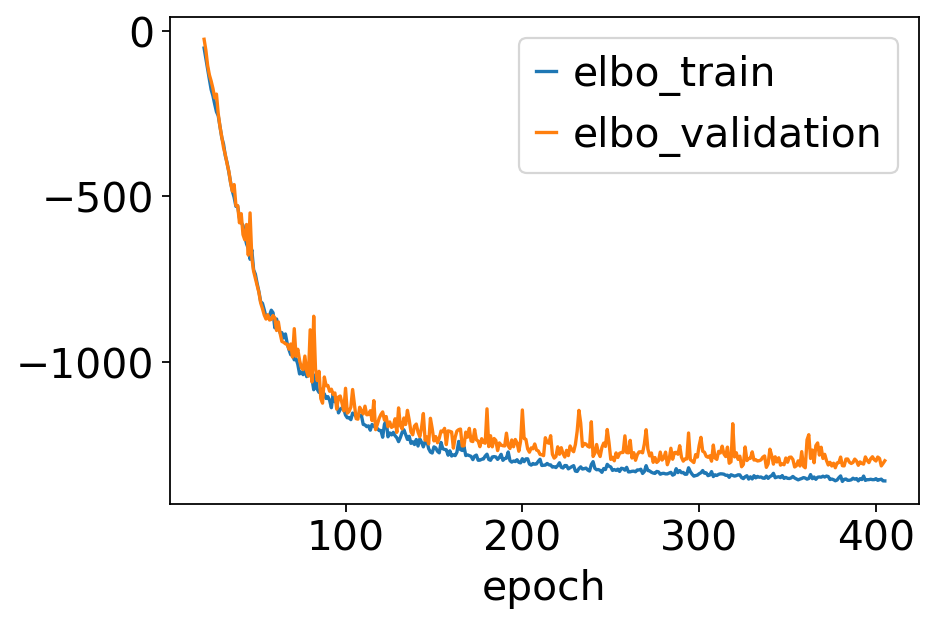

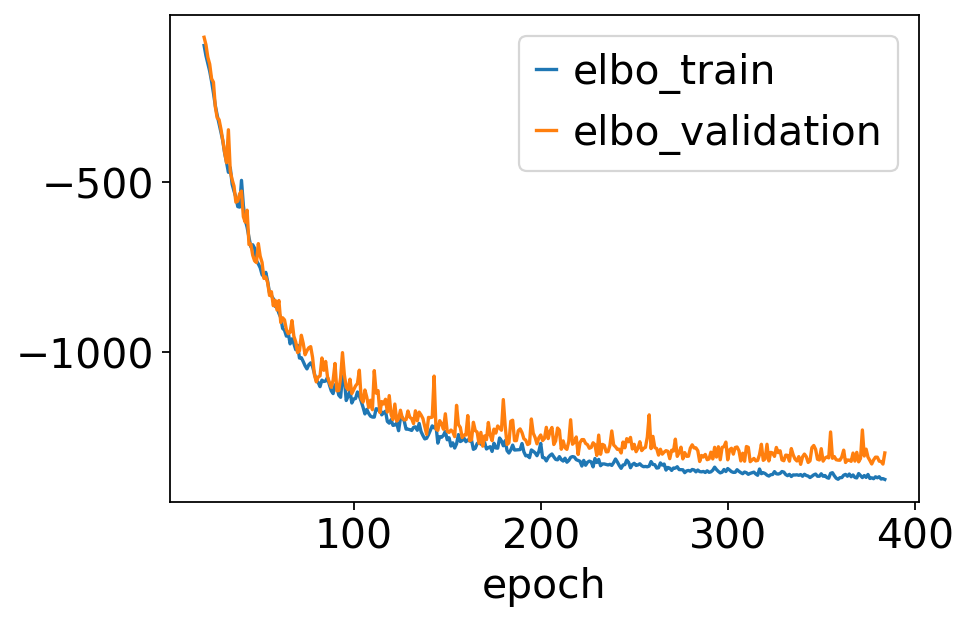

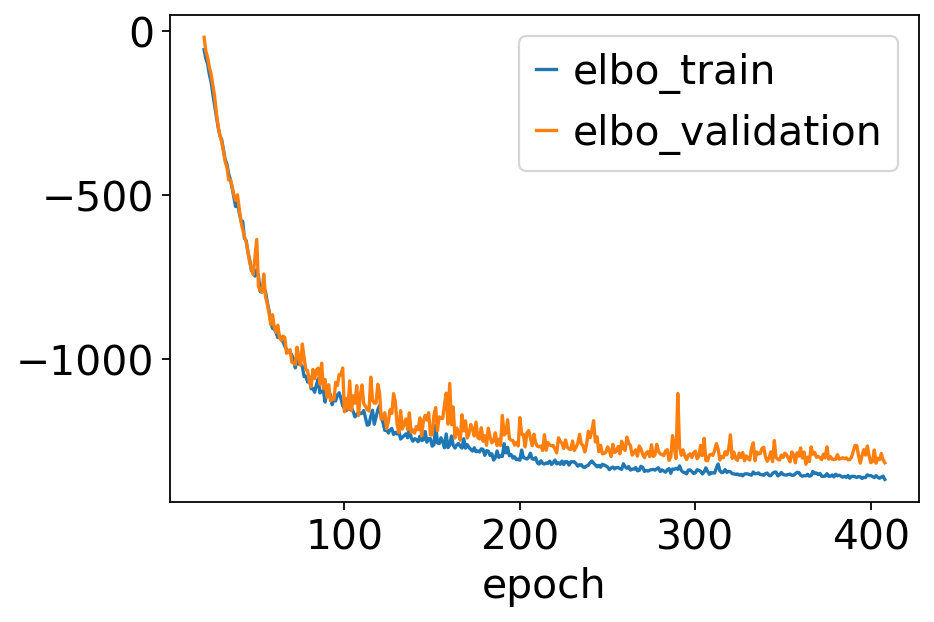

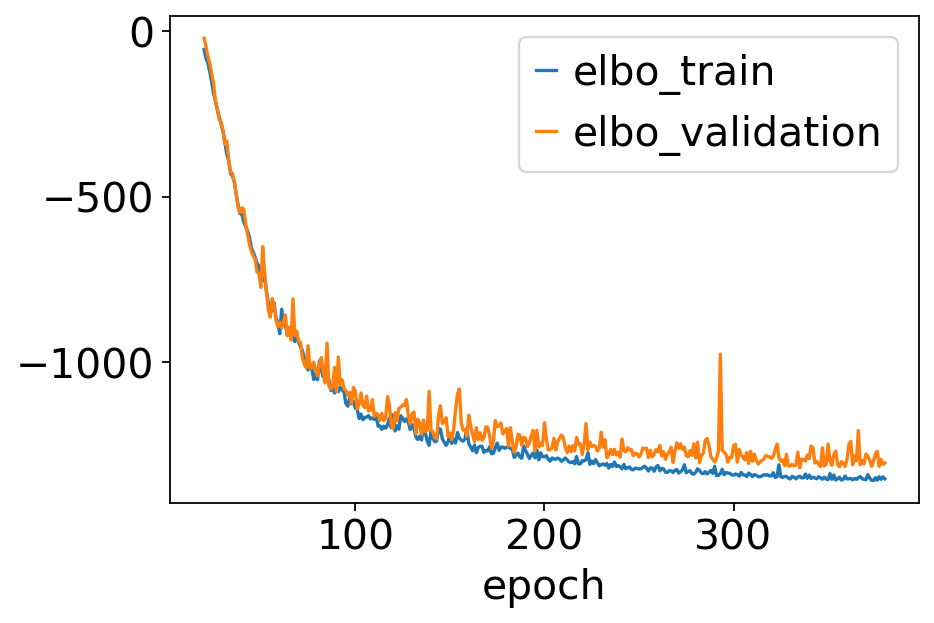

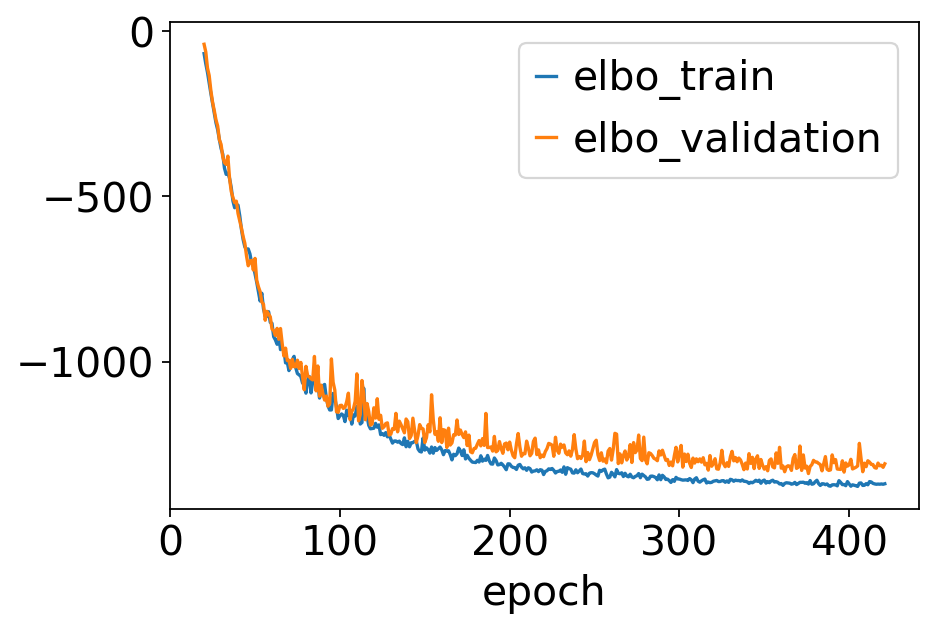

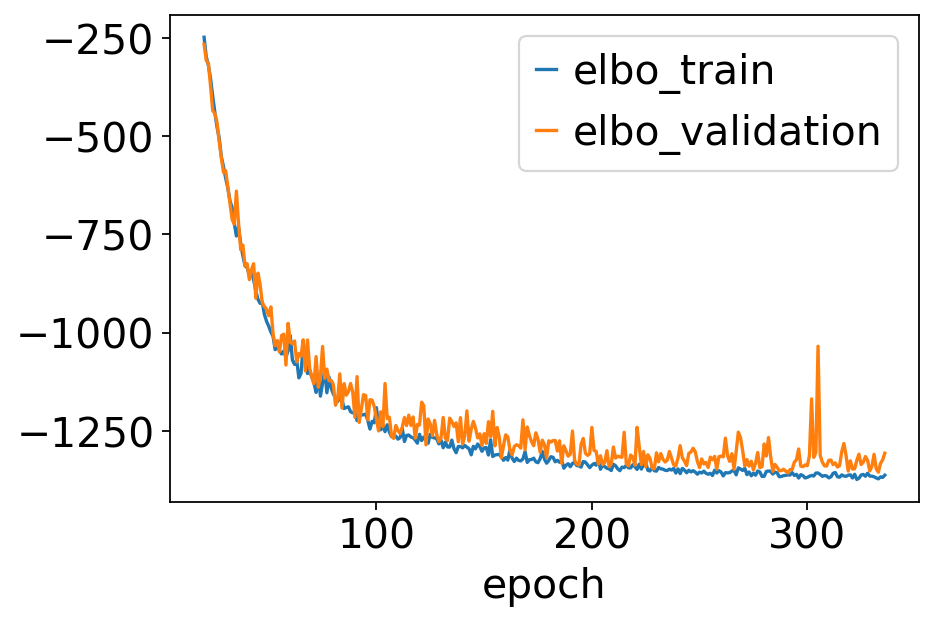

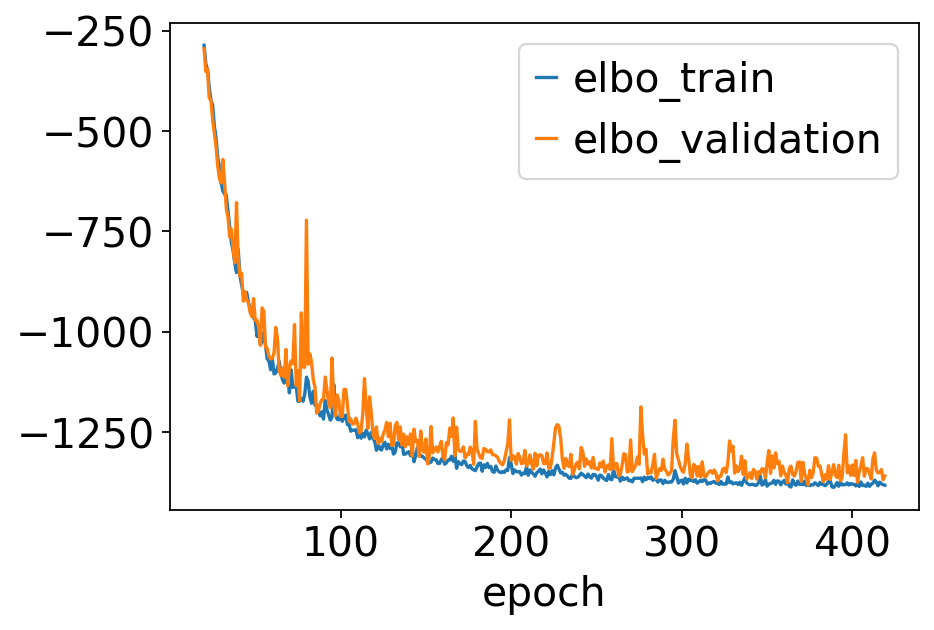

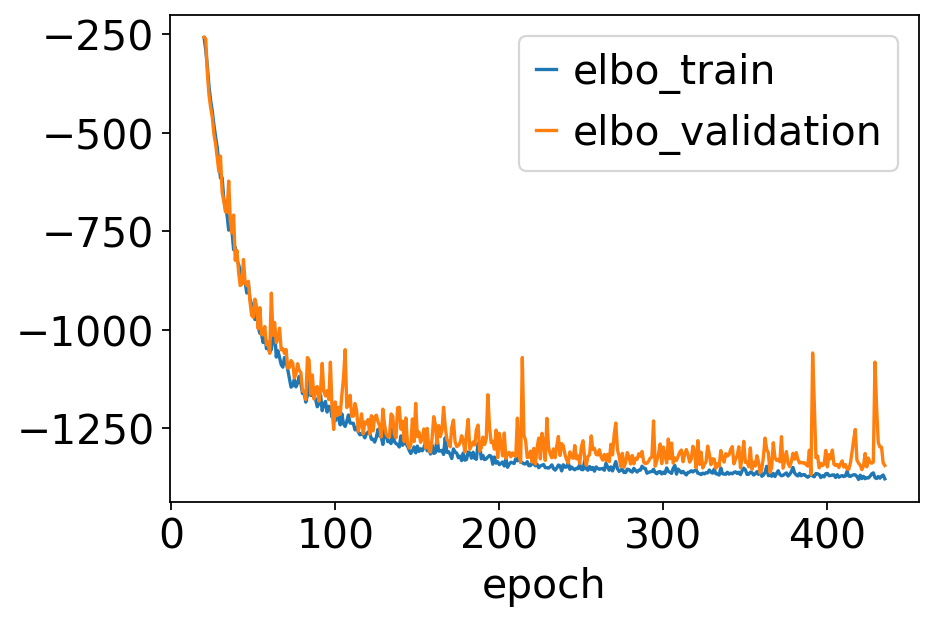

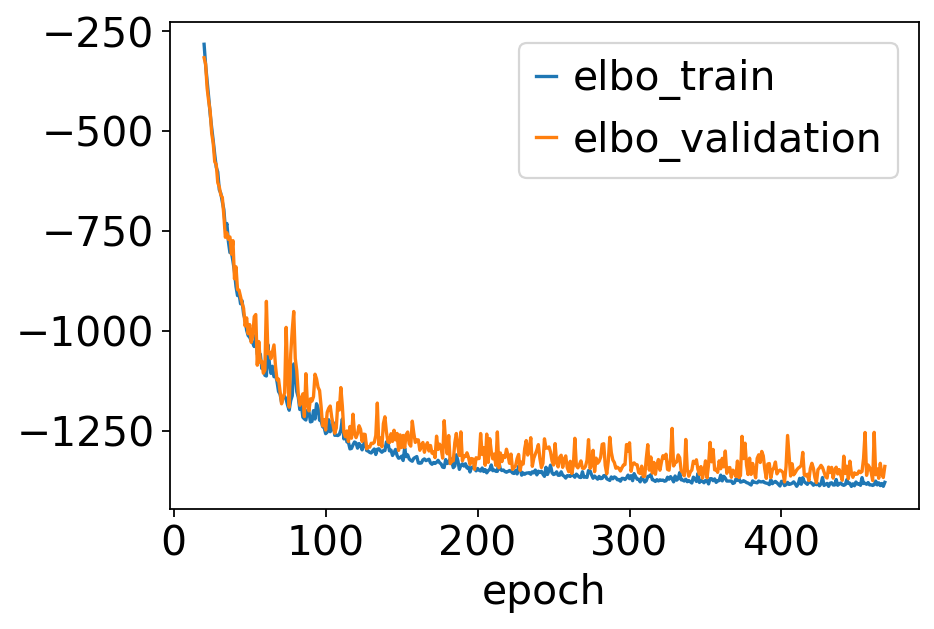

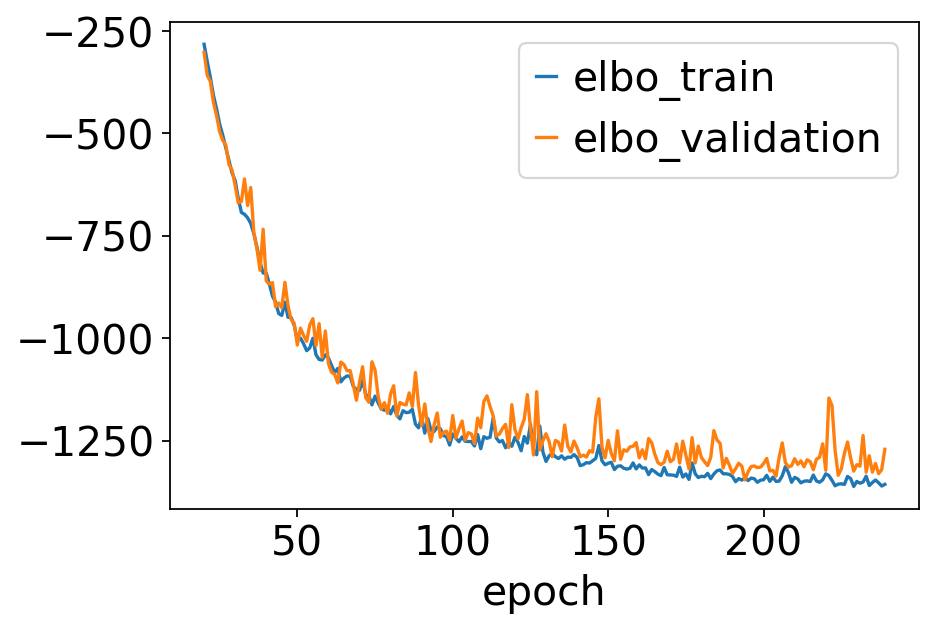

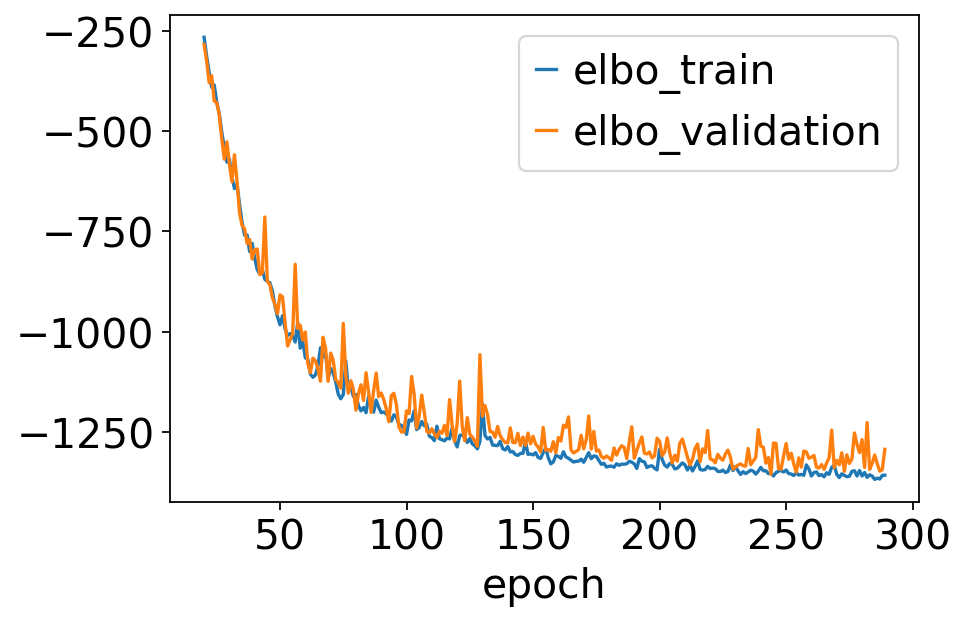

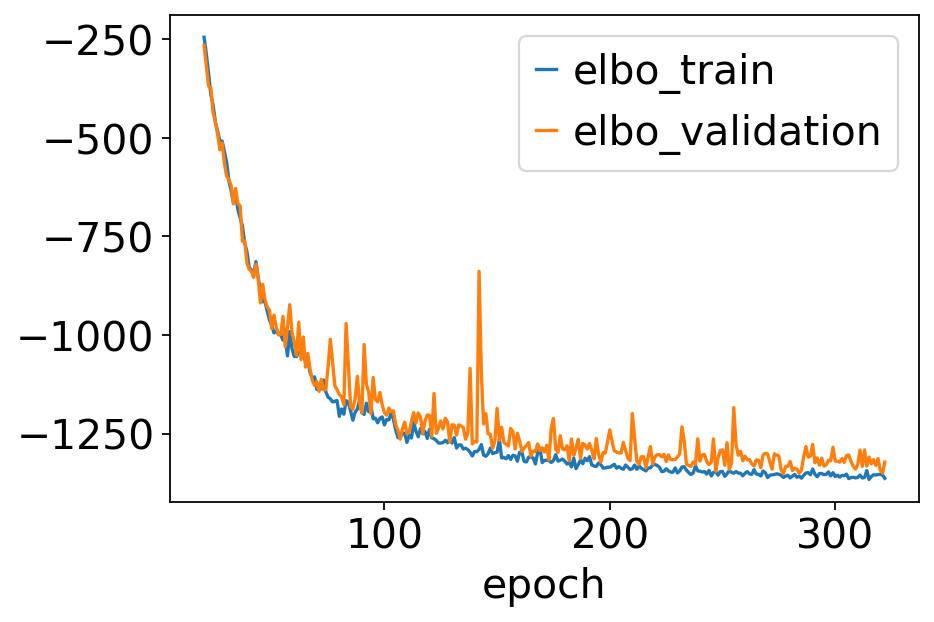

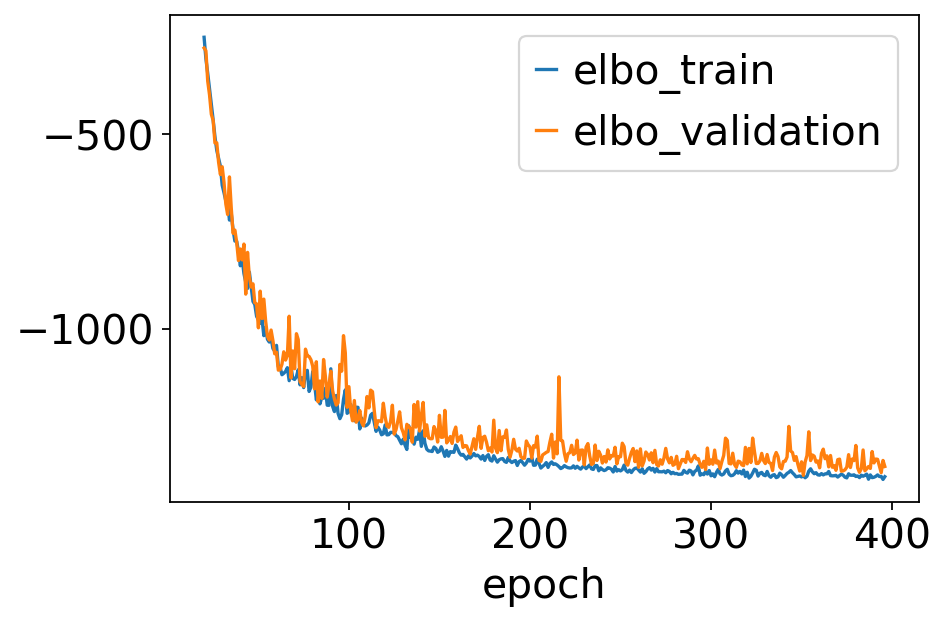

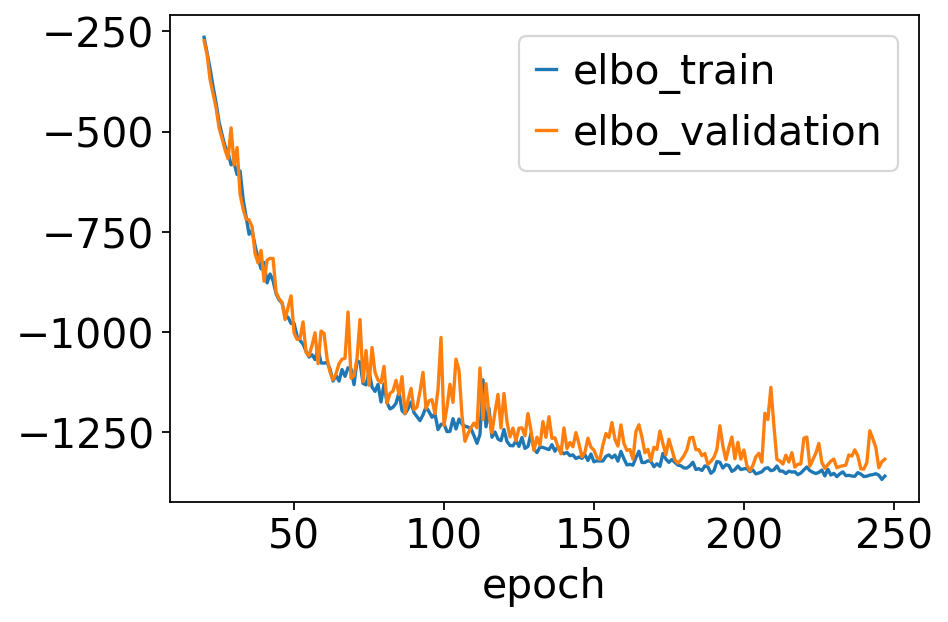

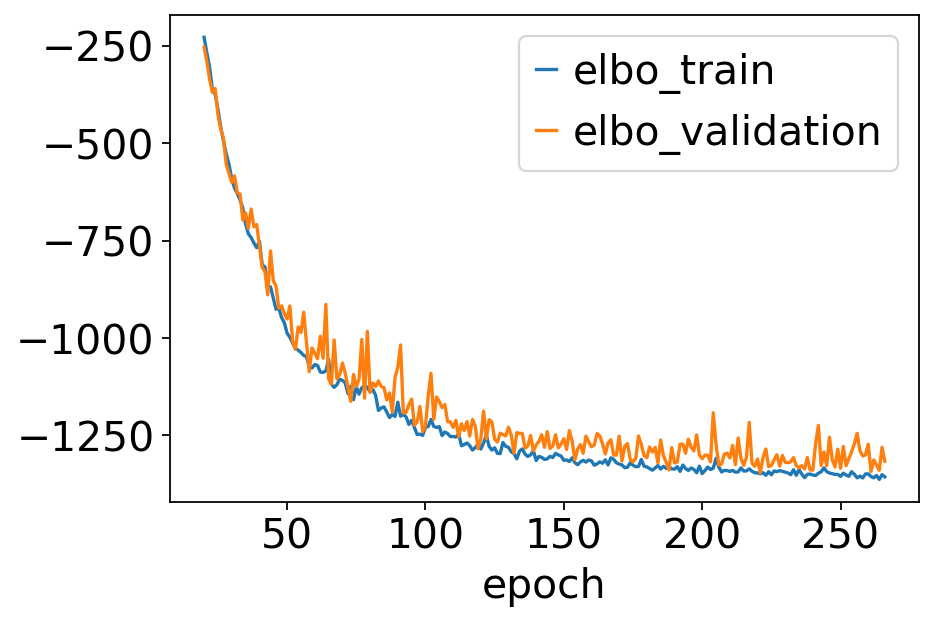

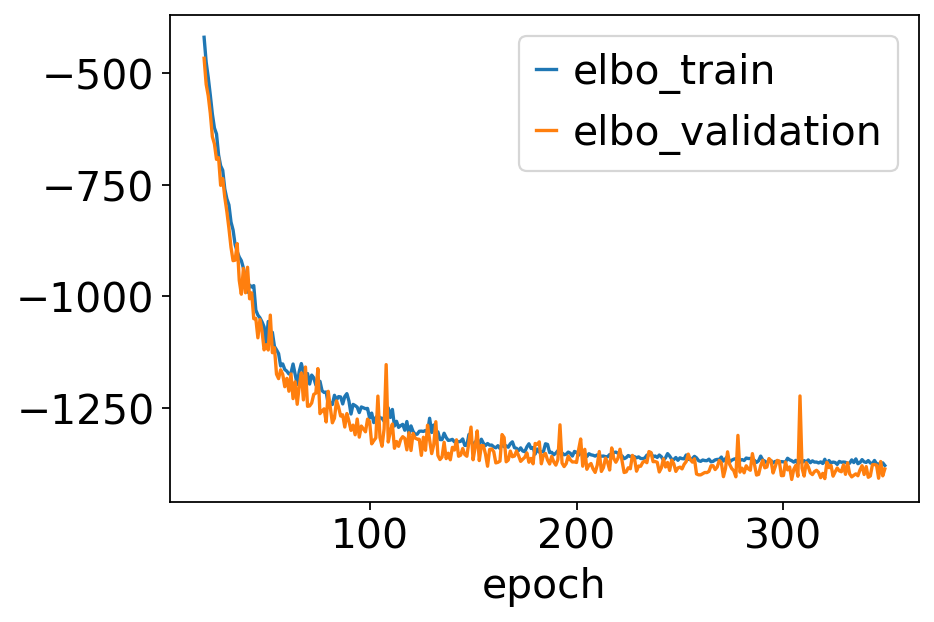

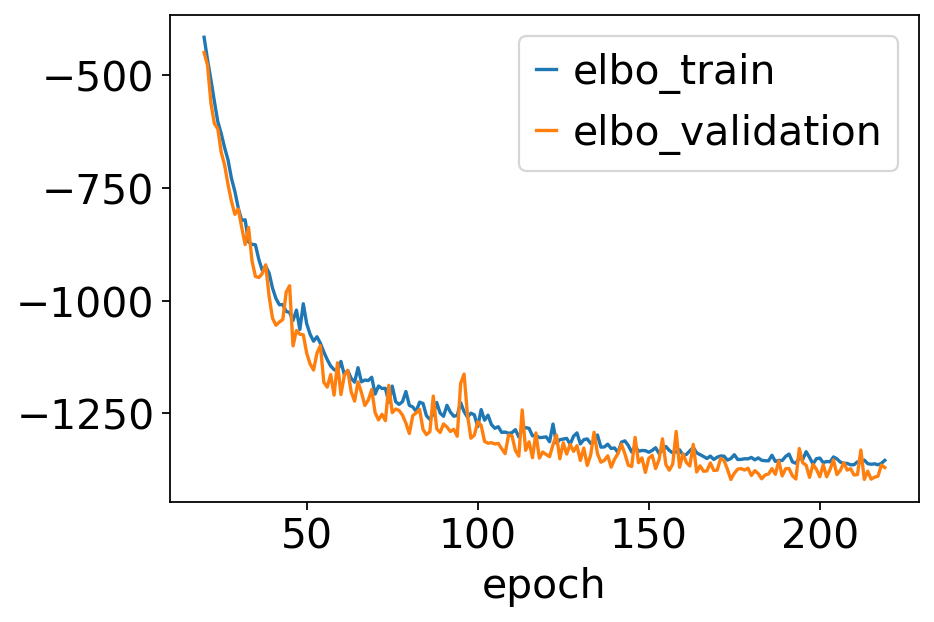

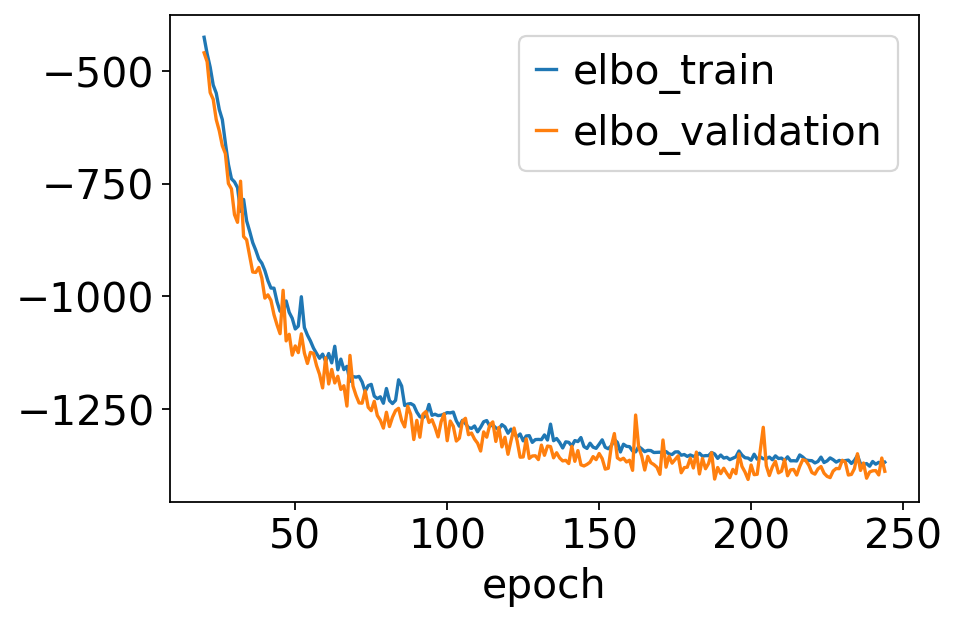

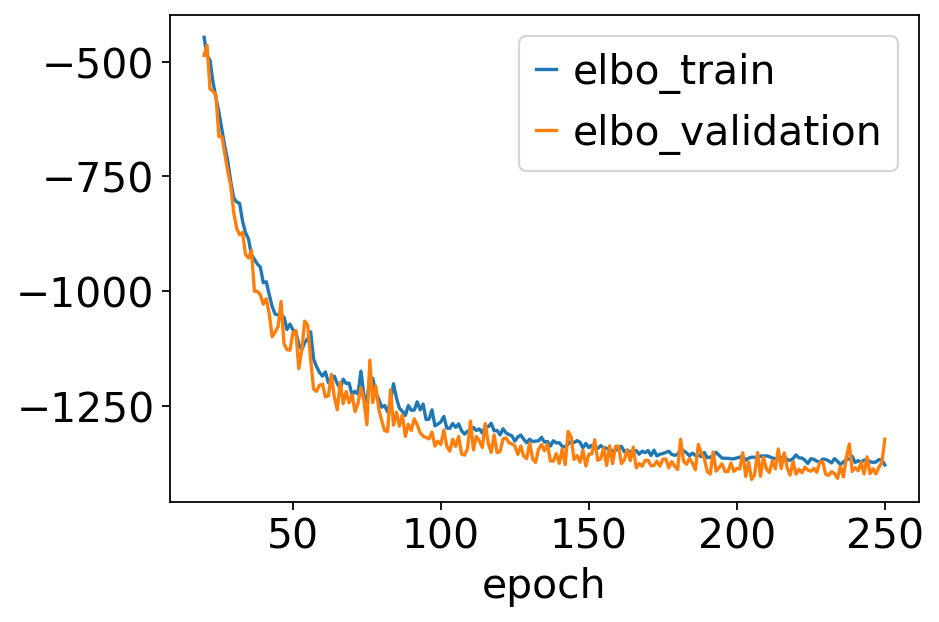

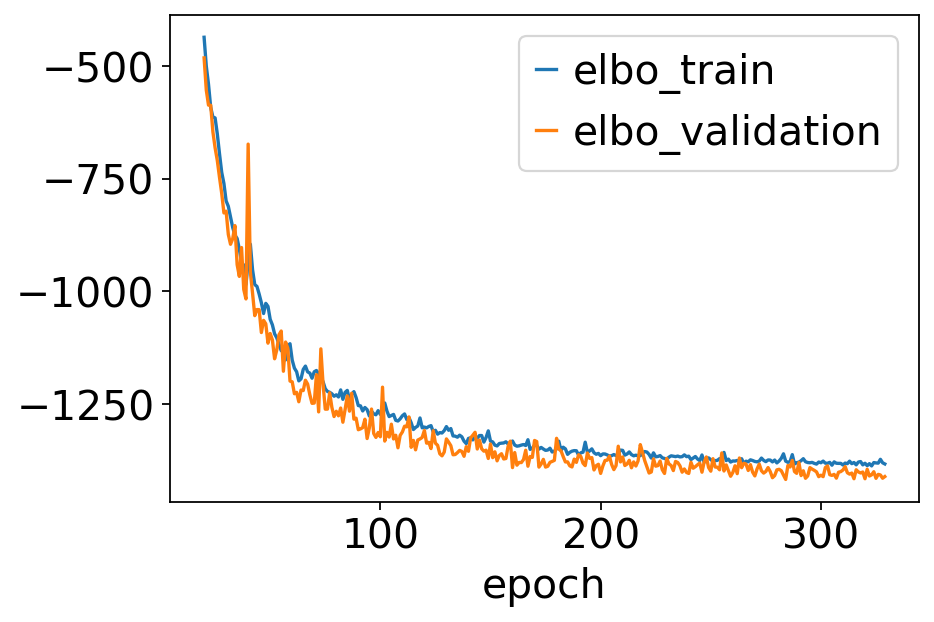

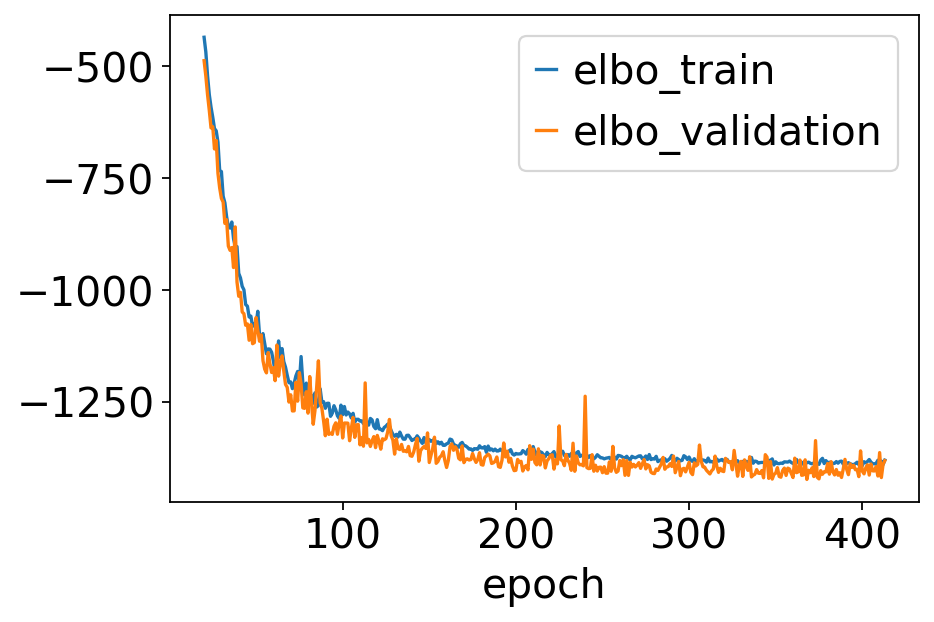

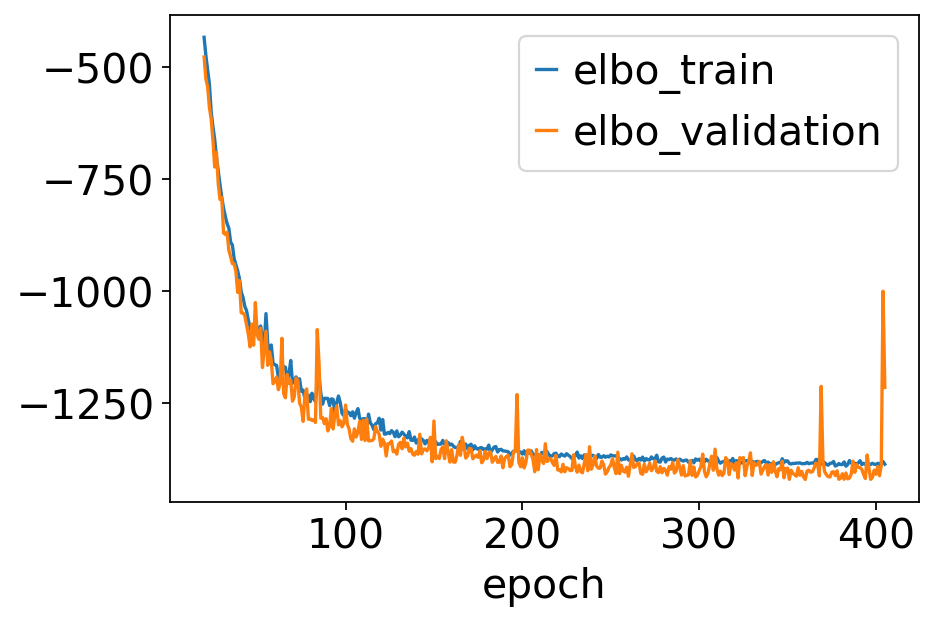

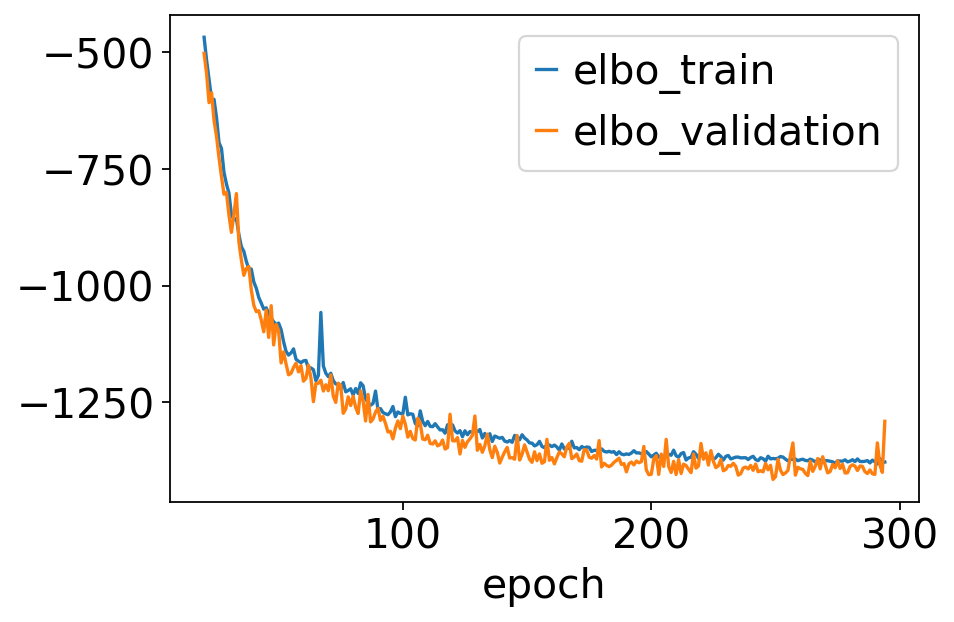

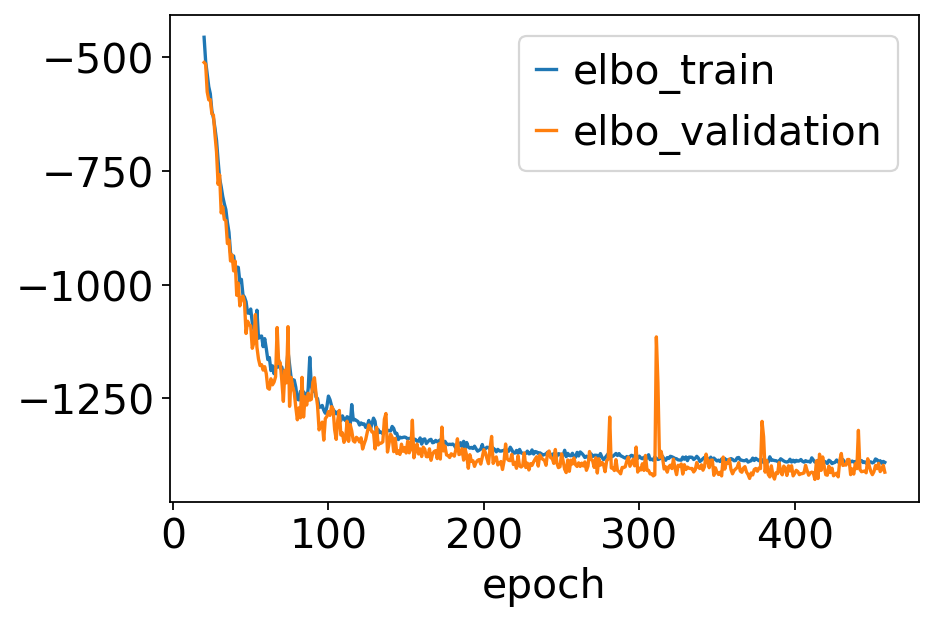

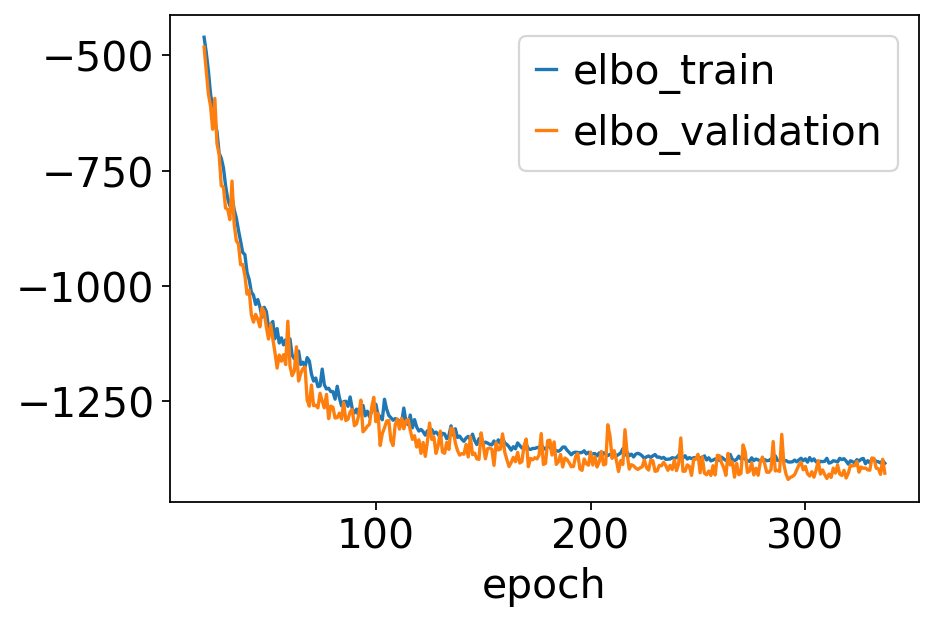

In [8]:
correlation_df = pd.DataFrame(columns=['correlation', 'method', 'n_obs', 'run'])

adatas = {}
bdatas = {}

mu = np.array([1, .2, .05])

R = np.array([[1., .2, .2],
              [.2, 1., .8],
              [.2, .8, 1.]])

C = np.array([.4, .4, .4])[:, None]

for n_obs in [1000, 2000, 3000, 4000, 5000]:
    for run_id in range(10):
        adata = get_adata(n_obs=n_obs, mu=mu, R=R, C=C)

        adata.var['true_ratio'] = np.array(adata.var.true_gamma / adata.var.true_beta)

        # Steady-state model
        adata.var['steady_state_ratio'] = adata.var['velocity_gamma']
        corr = pearsonr(adata.var['true_ratio'], adata.var['steady_state_ratio'])[0]
        correlation_df = correlation_df.append(
            {'correlation': corr, 'method': 'Steady-state', 'n_obs': n_obs, 'run': run_id}, ignore_index=True
        )

        # EM model
        scv.tl.recover_dynamics(
            adata, var_names=adata.var_names, use_raw=True, n_jobs=8
        )
        adata.var['em_ratio'] = adata.var['fit_gamma'] / adata.var['fit_beta']
        corr = pearsonr(adata.var['true_ratio'], adata.var['em_ratio'])[0]
        correlation_df = correlation_df.append(
            {'correlation': corr, 'method': 'EM', 'n_obs': n_obs, 'run': run_id}, ignore_index=True
        )
        
        
        adatas[f'({n_obs}, {run_id})'] = adata

        # VI model
        bdata = adata.copy()
        bdata.layers['Mu'] = bdata.layers['unspliced'].copy()
        bdata.layers['Ms'] = bdata.layers['spliced'].copy()

        """
        scaler = MinMaxScaler()
        bdata.layers["Ms"] = scaler.fit_transform(bdata.layers["spliced"])

        scaler = MinMaxScaler()
        bdata.layers["Mu"] = scaler.fit_transform(bdata.layers["unspliced"])
        """

        fit_velovi(bdata)
        bdata.var['vi_ratio'] = bdata.var['fit_gamma'] / bdata.var['fit_beta']
        corr = pearsonr(bdata.var['true_ratio'], bdata.var['vi_ratio'])[0]
        correlation_df = correlation_df.append(
            {'correlation': corr, 'method': 'VI', 'n_obs': n_obs, 'run': run_id}, ignore_index=True
        )
        bdatas[f'({n_obs}, {run_id})'] = bdata

In [9]:
correlation_df['method'] = correlation_df['method'].astype('category').cat.reorder_categories(['VI', 'EM', 'Steady-state'])

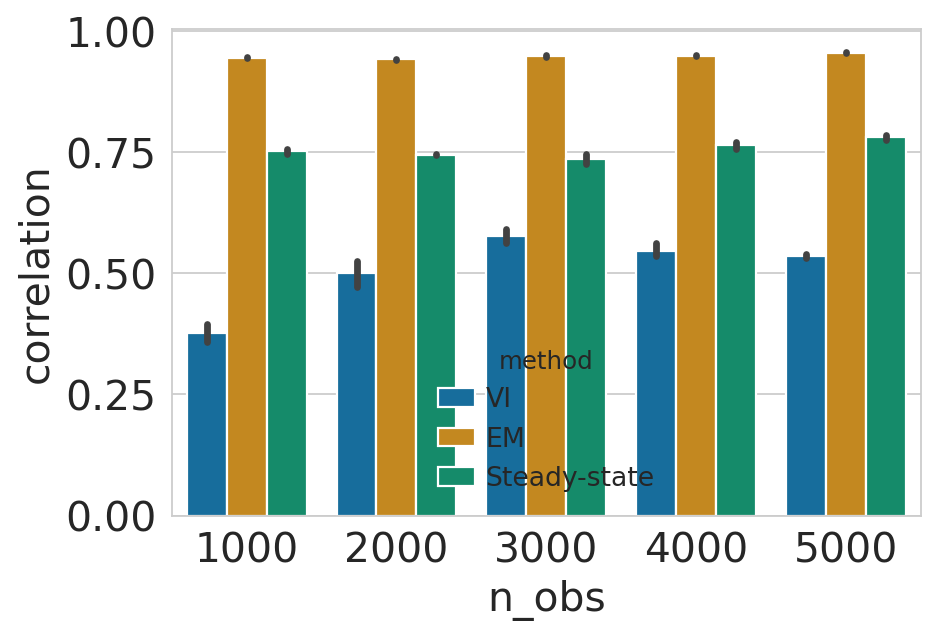

In [11]:
sns.set_style(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 4))
with mplscience.style_context():
    sns.barplot(
        data=correlation_df,
        x='n_obs',
        y='correlation',
        hue="method",
        ax=ax,
        palette='colorblind'
    )

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'correlation_estimated_rates_vs_ground_truth.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )